In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df=  pd.read_csv('CSV87 dane.csv',sep=';', decimal=',',index_col='Data godzina')

In [3]:
start = datetime.datetime.strptime("01-01-2017 1:00", "%d-%m-%Y %H:%M")
date_list = [start + relativedelta(hours=x) for x in range(0,11544)]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

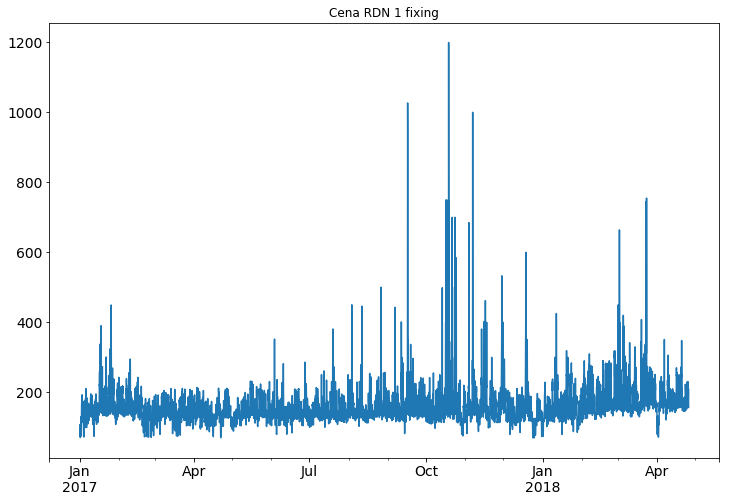

In [4]:
%matplotlib inline
df['RDN 1fix'].plot(figsize=(12,8), title= 'Cena RDN 1 fixing', fontsize=14)

In [5]:
b=df['RDN 1fix'][0:-24:]
feature_cols = ['Generacja wiatraków(PSE) w MWh','Krajowe Zapotrzebowanie na moc PSE','Generacja JWCD w MWh'] 
X = df[feature_cols][0:-24:]
feature_cols2 = ['Generacja wiatraków(PSE) w MWh','Krajowe Zapotrzebowanie na moc PSE','Generacja JWCD w MWh','Emisja CO2 EUR/Tona','Observation Poland National (C)']
X2 = df[feature_cols2][0:-24:]
feature_cols3 = ['Generacja wiatraków(PSE) w MWh','Krajowe Zapotrzebowanie na moc PSE','Generacja JWCD w MWh','Generacja nJWCD w MWh','Wymagana rezerwa mocy w MWh','Emisja CO2 EUR/Tona','Observation Poland National (C)']
X3= df[feature_cols3][0:-24:]

<Figure size 432x288 with 0 Axes>

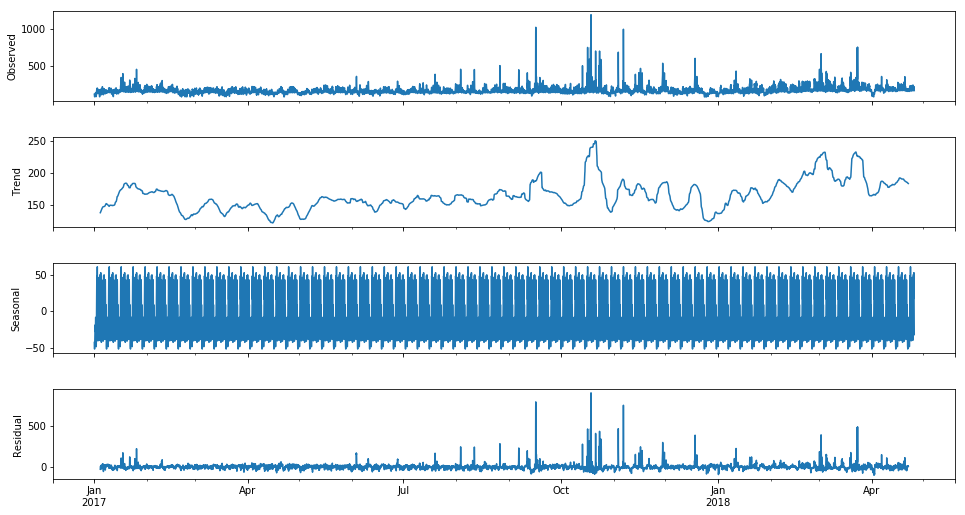

In [8]:
decomposition = seasonal_decompose(b,freq=24*7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [7]:
sezonowa=decomposition.seasonal

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=24).mean()
    rolstd = timeseries.rolling(window=24).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC',regression='ct')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


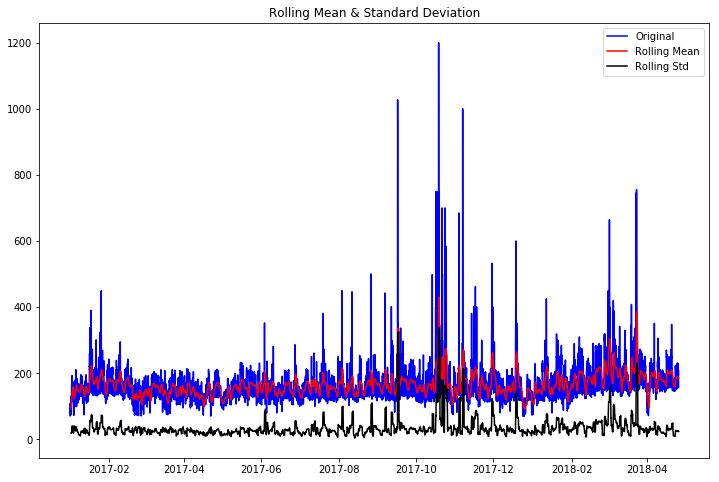

Results of Dickey-Fuller Test:
Test Statistic                -1.278903e+01
p-value                        2.576236e-20
#Lags Used                     4.000000e+01
Number of Observations Used    1.147900e+04
Critical Value (1%)           -3.959559e+00
Critical Value (5%)           -3.410873e+00
Critical Value (10%)          -3.127275e+00
dtype: float64


In [10]:
test_stationarity(b)

In [9]:
adfuller(b, autolag='AIC',regression='ctt')

(-12.978473832071117,
 3.165552662546933e-21,
 40,
 11479,
 {'1%': -4.3721397850796135,
  '5%': -3.832904573479532,
  '10%': -3.553578848469835},
 105452.77048672501)

In [10]:
from statsmodels.tsa.stattools import kpss
kpss(b,regression='ct',lags=24)

C:\Users\Blizzardzik\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(0.36580892504693585,
 0.01,
 24,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [64]:
## niewielkie wartości p-value wskazują na stacjonarność i odrzucenie Hipotezy zerowej mówiącej o 
#występowaniu pierwiastka jednostkowego

In [105]:
treningowy=df['RDN 1fix'][0:-288:]
testowy=df['RDN 1fix'][-288:]
treningowy
feature_cols = ['Generacja wiatraków(PSE) w MWh','Krajowe Zapotrzebowanie na moc PSE','Generacja JWCD w MWh'] 
X = df[feature_cols][0:-288:]
Xoos = df[feature_cols][-288:]

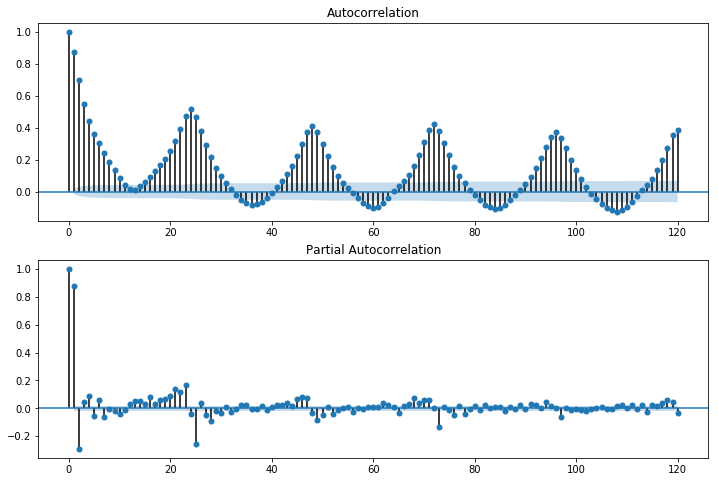

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(b, lags=120, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(b, lags=120, ax=ax2)

In [106]:
model = sm.tsa.statespace.SARIMAX(treningowy ,exog=X,trend='ct', order=(2,0,2), seasonal_order=(0,0,0,0))
results1 = model.fit()
print (results1.summary())

C:\Users\Blizzardzik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:               RDN 1fix   No. Observations:                11256
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -51852.823
Date:                Wed, 29 Aug 2018   AIC                         103725.646
Time:                        17:51:19   BIC                         103798.932
Sample:                    01-01-2017   HQIC                        103750.308
                         - 04-15-2018                                         
Covariance Type:                  opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                             -4.2341      1.350     -3.137      0.002      -6.880      -1.588
drift                                  0.0007      0.000   

In [123]:
model = sm.tsa.statespace.SARIMAX(treningowy, exog=X,trend='ct', order=(1,0,0), seasonal_order=(2,0,0,24),simple_differencing=True)
results2 = model.fit()
print (results2.summary())

C:\Users\Blizzardzik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                           RDN 1fix   No. Observations:                11256
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 24)   Log Likelihood              -51692.116
Date:                            Wed, 29 Aug 2018   AIC                         103402.231
Time:                                    18:19:57   BIC                         103468.189
Sample:                                01-01-2017   HQIC                        103424.427
                                     - 04-15-2018                                         
Covariance Type:                              opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                             -3.4844      1.253     -2.78

In [163]:
model = sm.tsa.statespace.SARIMAX(treningowy,exog=X,trend='ct', order=(3,0,0), seasonal_order=(2,0,1,24),simple_differencing=True)
results3 = model.fit()
print (results3.summary())

C:\Users\Blizzardzik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                           RDN 1fix   No. Observations:                11256
Model:             SARIMAX(3, 0, 0)x(2, 0, 1, 24)   Log Likelihood              -51406.164
Date:                            Wed, 29 Aug 2018   AIC                         102836.328
Time:                                    20:42:19   BIC                         102924.272
Sample:                                01-01-2017   HQIC                        102865.922
                                     - 04-15-2018                                         
Covariance Type:                              opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                             -4.1443      1.195     -3.46

In [156]:
print(results3.mle_retvals)

{'fopt': 4.568487961948459, 'gopt': array([-3.57048258e-04, -5.66983780e-01, -6.67320700e-02, -4.10551462e-01,
       -2.43681172e-01, -4.86705698e-04, -2.27717271e-02,  2.34662068e-02,
       -6.72578775e-03,  3.10354560e-03]), 'fcalls': 671, 'warnflag': 1, 'converged': False, 'iterations': 50}


In [14]:
Xoos=df[feature_cols][-24:]

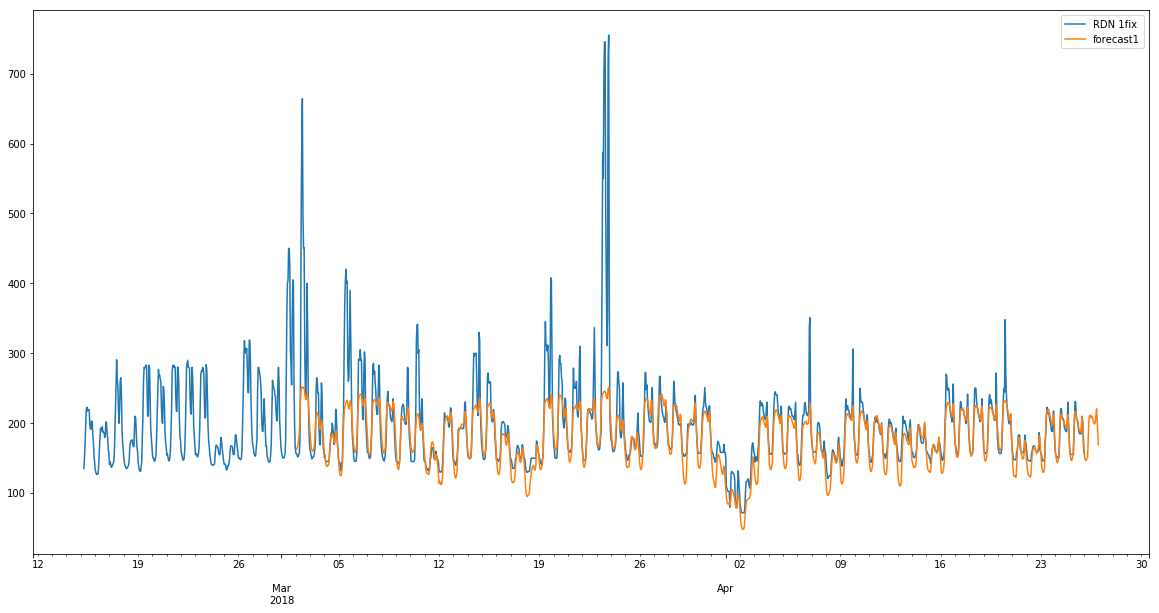

In [108]:
df['forecast1'] = results1.predict(start = 10200, end= 11543, dynamic= True,exog=Xoos)  
df[['RDN 1fix', 'forecast1']][-1700:].plot(figsize=(20, 10))

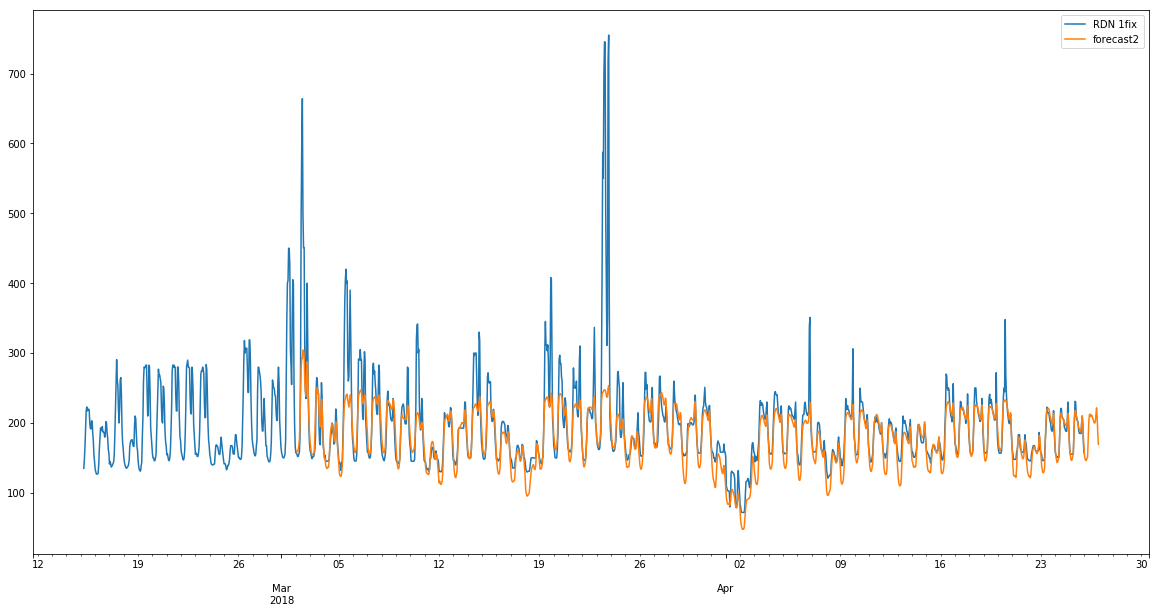

In [125]:
Xoos=df[feature_cols][-288:] ##tutaj exogeniczne do ostatnich 24h jako wsad do prognozy do pierwszego modelu
df['forecast2'] = results2.predict(start = 10200, end= 11543, dynamic= True,exog=Xoos)  
df[['RDN 1fix', 'forecast2']][-1700:].plot(figsize=(20, 10))

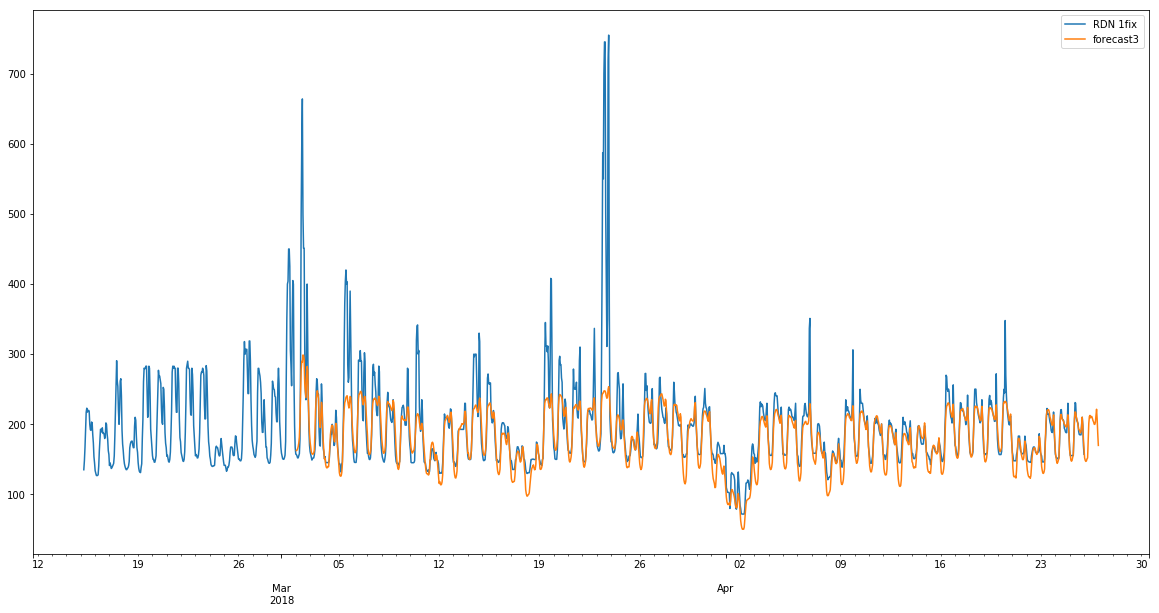

In [166]:
Xoos=df[feature_cols][-288:]
df['forecast3'] = results3.predict(start = 10200, end= 11543, dynamic= True,exog=Xoos)  
df[['RDN 1fix', 'forecast3']][-1700:].plot(figsize=(20, 10))

In [181]:
Xoos=df[feature_cols][-24:] ##tutaj exogeniczne do ostatnich 24h jako wsad do prognozy do pierwszego modelu
print(Xoos)

                     Generacja wiatraków(PSE) w MWh  \
2018-04-26 01:00:00                          1613.0   
2018-04-26 02:00:00                          1443.0   
2018-04-26 03:00:00                          1329.0   
2018-04-26 04:00:00                          1283.0   
2018-04-26 05:00:00                          1265.0   
2018-04-26 06:00:00                          1280.0   
2018-04-26 07:00:00                          1292.0   
2018-04-26 08:00:00                          1309.0   
2018-04-26 09:00:00                          1360.0   
2018-04-26 10:00:00                          1509.0   
2018-04-26 11:00:00                          1686.0   
2018-04-26 12:00:00                          1790.0   
2018-04-26 13:00:00                          1832.0   
2018-04-26 14:00:00                          1863.0   
2018-04-26 15:00:00                          1871.0   
2018-04-26 16:00:00                          1859.0   
2018-04-26 17:00:00                          1811.0   
2018-04-26

In [166]:
#start = datetime.datetime.strptime("2018-04-26 02:00", "%Y-%m-%d %H:%M") ## tutaj auto of sample bez egzogenicznych
#date_list = [start + relativedelta(hours=x) for x in range(0,24)]
#future = pd.DataFrame(index=date_list, columns= df.columns)
#df = pd.concat([df, future])#

In [128]:
wyniki = pd.DataFrame()
wyniki['Actual']= df['RDN 1fix'][11256:11520]
wyniki['predicted']= df['forecast2'][11256:11520]
wyniki.columns=['Actual','predicted']
#wyniki=wyniki.sort_values(by=['Actual'])#
wyniki['index']=range(len(wyniki))

In [129]:
from sklearn.metrics import r2_score   #błędy modelu nr. 2##
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
from math import sqrt
r=r2_score(wyniki['Actual'],wyniki['predicted'])
msle=mean_squared_log_error(wyniki['Actual'],wyniki['predicted'])
mse=mean_squared_error(wyniki['Actual'],wyniki['predicted'])
mae=mean_absolute_error(wyniki['Actual'],wyniki['predicted'])
evs=explained_variance_score(wyniki['Actual'],wyniki['predicted'])
medianae=median_absolute_error(wyniki['Actual'],wyniki['predicted'])
mape=np.mean(np.abs((wyniki['Actual'] -wyniki['predicted']) / wyniki['Actual'])) * 100
rmse=sqrt(mean_squared_error(wyniki['Actual'],wyniki['predicted']))
bledy1= np.array([['r2_score','mean squared log error','mean squared error','mean absolute error','explained variance score','median absolute error','MAPE','RMSE'],[r,msle,mse,mae,evs,medianae,mape,rmse]],dtype='U25')
df2 = pd.DataFrame(data=bledy1,columns=bledy1[0])
Bledy2=df2.drop(0)
Bledy2.head()

,r2_score,mean squared log error,mean squared error,mean absolute error,explained variance score,median absolute error,MAPE,RMSE
1,0.8287641119713105,0.005083788193142813,184.14398235644177,8.67666793648725,0.8522281343490976,5.80021098598759,4.683564102246372,13.569966188478208


In [167]:
wyniki2 = pd.DataFrame()
wyniki2['Actual']= df['RDN 1fix'][11256:11520]
wyniki2['predicted']= df['forecast3'][11256:11520]
wyniki2.columns=['Actual','predicted']
#wyniki=wyniki.sort_values(by=['Actual'])#
wyniki2['index']=range(len(wyniki2))

In [168]:
from sklearn.metrics import r2_score   #błędy modelu #nr3#
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
from math import sqrt
r=r2_score(wyniki2['Actual'],wyniki2['predicted'])
msle=mean_squared_log_error(wyniki2['Actual'],wyniki2['predicted'])
mse=mean_squared_error(wyniki2['Actual'],wyniki2['predicted'])
mae=mean_absolute_error(wyniki2['Actual'],wyniki2['predicted'])
evs=explained_variance_score(wyniki2['Actual'],wyniki2['predicted'])
medianae=median_absolute_error(wyniki2['Actual'],wyniki2['predicted'])
mape=np.mean(np.abs((wyniki2['Actual'] -wyniki2['predicted']) / wyniki2['Actual'])) * 100
rmse=sqrt(mean_squared_error(wyniki2['Actual'],wyniki2['predicted']))
bledy1= np.array([['r2_score','mean squared log error','mean squared error','mean absolute error','explained variance score','median absolute error','MAPE','RMSE'],[r,msle,mse,mae,evs,medianae,mape,rmse]],dtype='U25')
df3 = pd.DataFrame(data=bledy1,columns=bledy1[0])
Bledy3=df3.drop(0)
Bledy3.head()

,r2_score,mean squared log error,mean squared error,mean absolute error,explained variance score,median absolute error,MAPE,RMSE
1,0.8343064535544792,0.0047398827619826054,178.18384828376773,8.461726460197019,0.8539711336002157,5.677684714625684,4.53866980976848,13.34855229168196


In [109]:
wyniki3 = pd.DataFrame()
wyniki3['Actual']= df['RDN 1fix'][11256:11520]
wyniki3['predicted']= df['forecast1'][11256:11520]
wyniki3.columns=['Actual','predicted']
#wyniki=wyniki.sort_values(by=['Actual'])#
wyniki3['index']=range(len(wyniki3))

In [110]:
from sklearn.metrics import r2_score   #błędy modelu #nr3#
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
from math import sqrt
r=r2_score(wyniki3['Actual'],wyniki3['predicted'])
msle=mean_squared_log_error(wyniki3['Actual'],wyniki3['predicted'])
mse=mean_squared_error(wyniki3['Actual'],wyniki3['predicted'])
mae=mean_absolute_error(wyniki3['Actual'],wyniki3['predicted'])
evs=explained_variance_score(wyniki3['Actual'],wyniki3['predicted'])
medianae=median_absolute_error(wyniki3['Actual'],wyniki3['predicted'])
mape=np.mean(np.abs((wyniki3['Actual'] -wyniki3['predicted']) / wyniki3['Actual'])) * 100
rmse=sqrt(mean_squared_error(wyniki3['Actual'],wyniki3['predicted']))
bledy1= np.array([['r2_score','mean squared log error','mean squared error','mean absolute error','explained variance score','median absolute error','MAPE','RMSE'],[r,msle,mse,mae,evs,medianae,mape,rmse]],dtype='U25')
df4 = pd.DataFrame(data=bledy1,columns=bledy1[0])
Bledy3=df4.drop(0)
Bledy3.head()

,r2_score,mean squared log error,mean squared error,mean absolute error,explained variance score,median absolute error,MAPE,RMSE
1,0.829307475993876,0.004912620372523321,183.5596584969032,8.556949864364032,0.855162931783449,5.2658529804601955,4.58922163297701,13.548419040497057


In [59]:
k=np.asarray(Bledy3)
k

array([['0.8355057217529716', '0.004702212773833671',
        '176.89417691565586', '8.445127232397477', '0.8540732898761447',
        '5.724725712121057', '4.530105632629121', '13.300157025977395']],
      dtype=object)

In [134]:
df['forecast2'][-24:] ## tutaj prognoza na dzień nastepny 26.04

2018-04-26 01:00:00    151.459999
2018-04-26 02:00:00    147.916588
2018-04-26 03:00:00    146.283615
2018-04-26 04:00:00    146.934857
2018-04-26 05:00:00    149.861624
2018-04-26 06:00:00    151.306860
2018-04-26 07:00:00    177.520307
2018-04-26 08:00:00    201.423271
2018-04-26 09:00:00    211.360947
2018-04-26 10:00:00    212.804646
2018-04-26 11:00:00    209.306065
2018-04-26 12:00:00    211.352327
2018-04-26 13:00:00    211.326163
2018-04-26 14:00:00    208.760279
2018-04-26 15:00:00    205.401012
2018-04-26 16:00:00    203.621778
2018-04-26 17:00:00    200.231199
2018-04-26 18:00:00    199.799949
2018-04-26 19:00:00    202.525340
2018-04-26 20:00:00    211.551058
2018-04-26 21:00:00    221.692449
2018-04-26 22:00:00    207.848173
2018-04-26 23:00:00    186.549013
2018-04-27 00:00:00    169.464685
Name: forecast2, dtype: float64

Figure(1080x720)


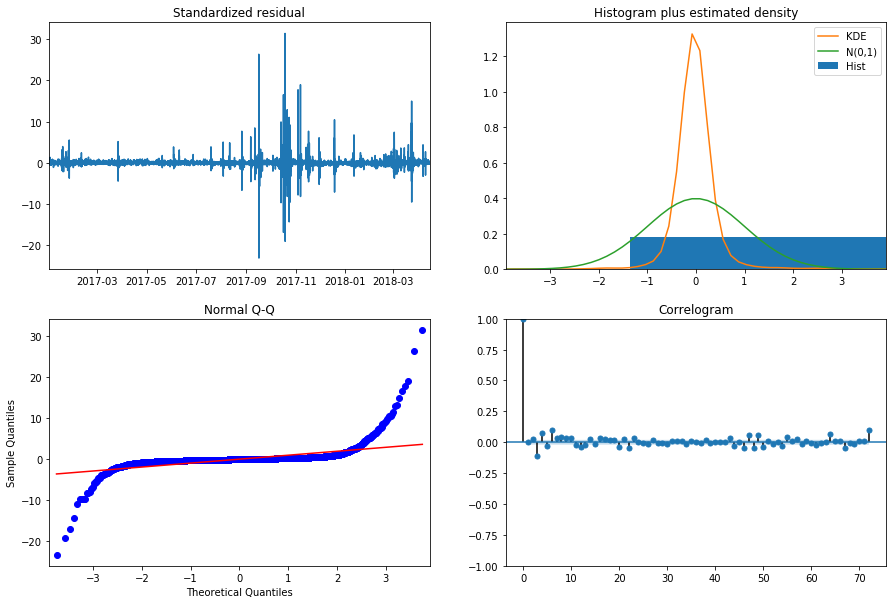

In [175]:
print(results3.plot_diagnostics(lags=72,figsize=(15,10))) ##testowanie reszt modelu##

Figure(2160x2160)


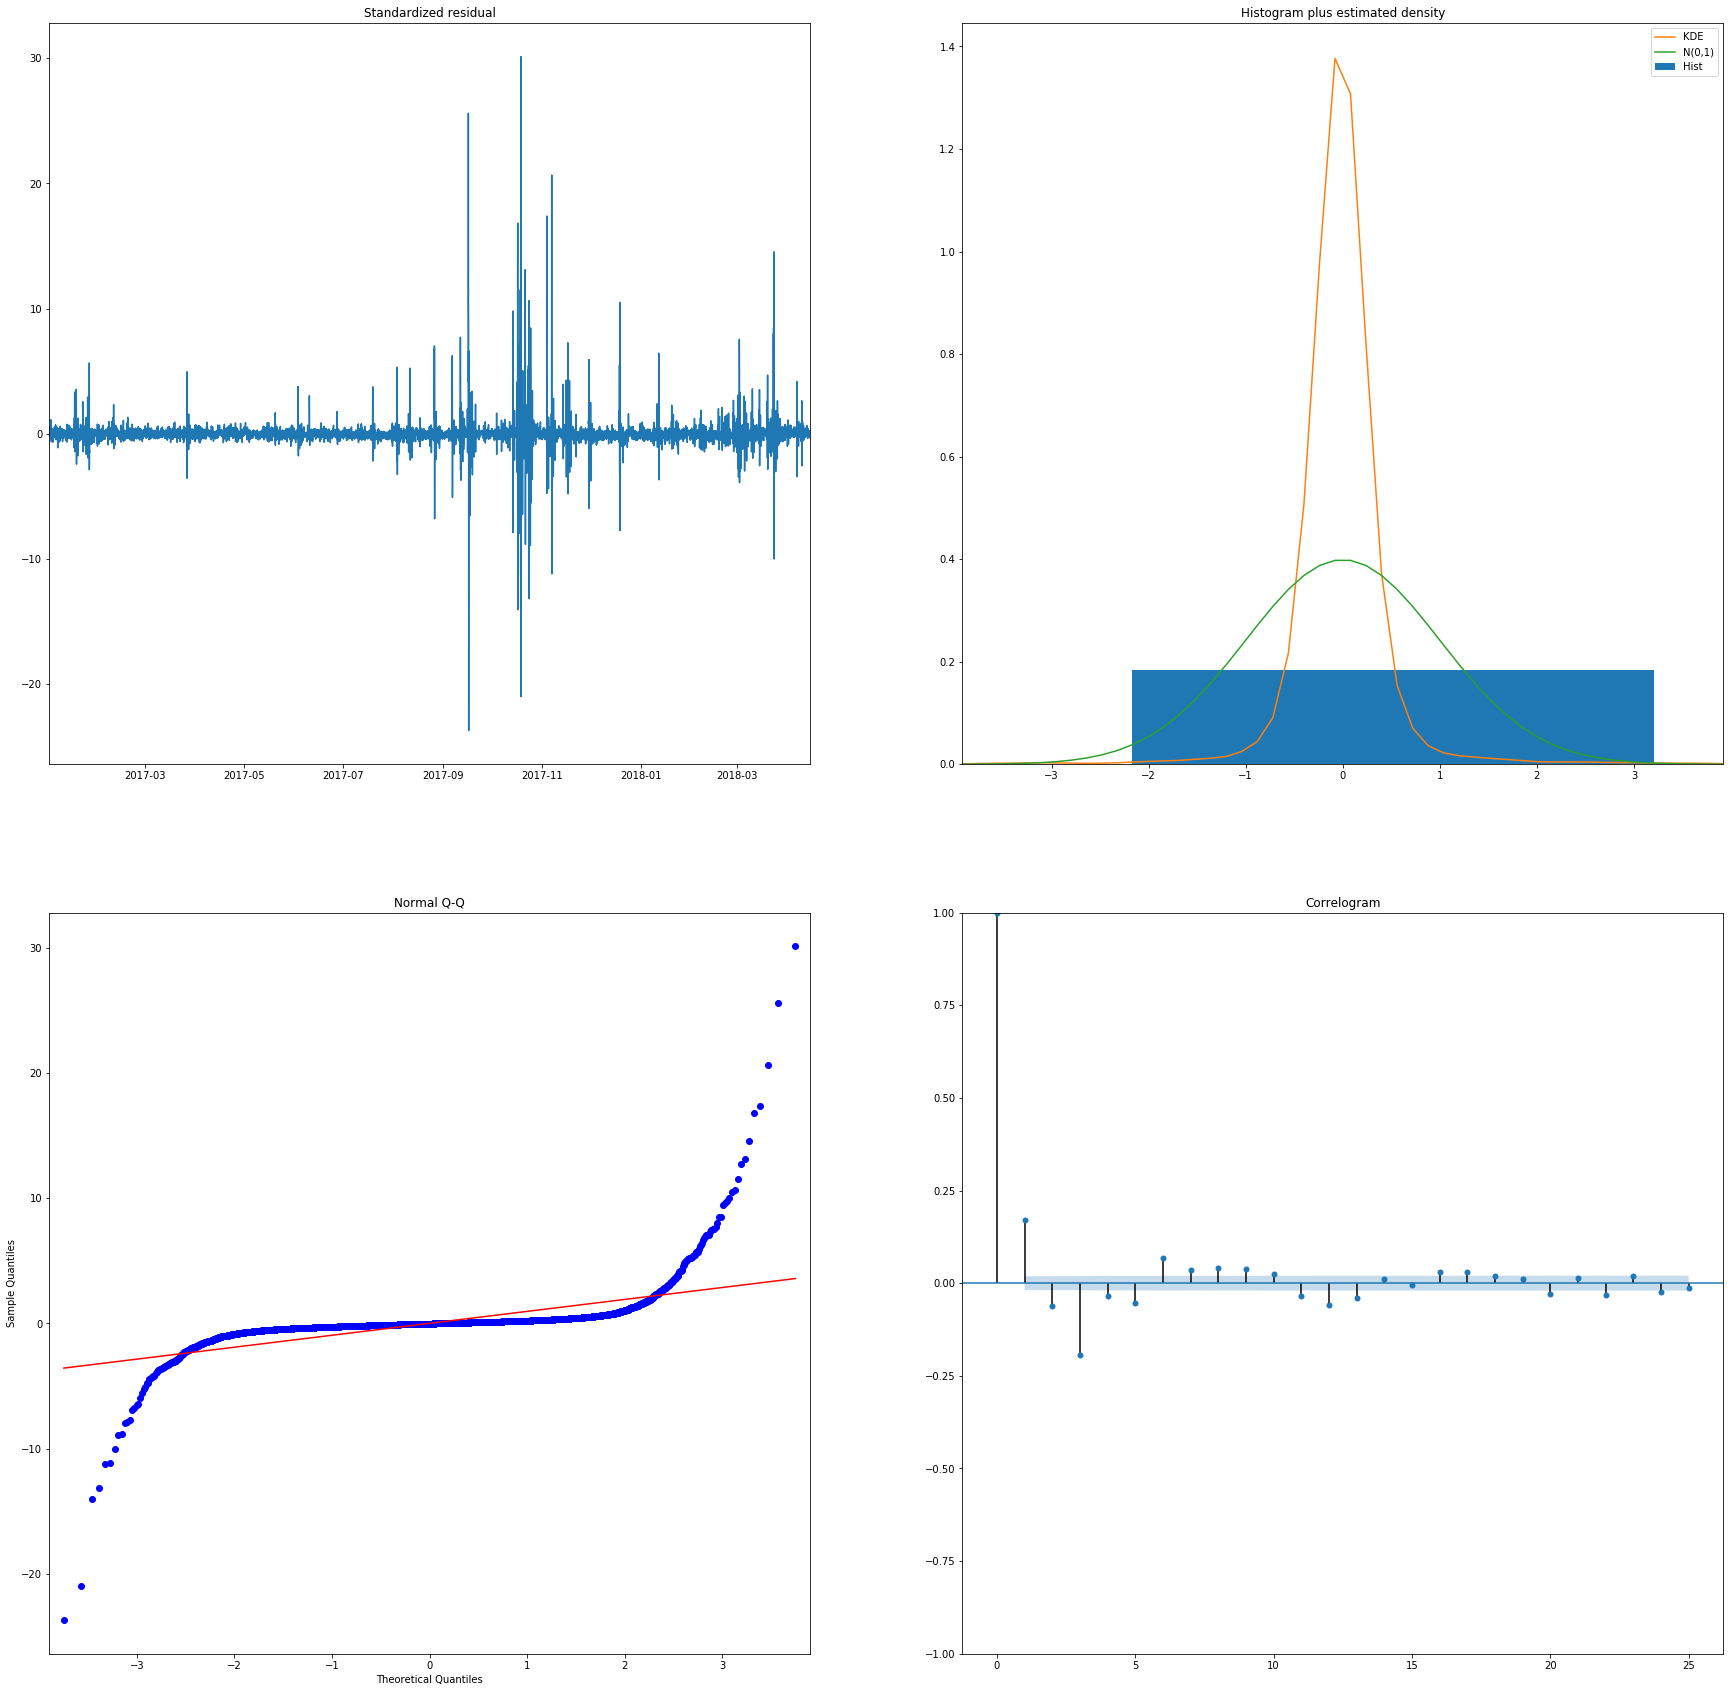

In [150]:
print(results2.plot_diagnostics(lags=25,figsize=(30,30)))

In [63]:
print(results2.test_serial_correlation(method='ljungbox',lags=200))

[[[1.03706882e+00 2.76454057e+00 2.15419694e+01 3.76190549e+01
   8.94584206e+01 2.20728579e+02 2.25834188e+02 2.25910859e+02
   2.48791016e+02 2.59120102e+02 2.62782673e+02 2.69067677e+02
   2.70584123e+02 2.70747531e+02 2.82025761e+02 2.85994858e+02
   2.86129129e+02 2.96888799e+02 3.06015442e+02 3.16156656e+02
   3.32561035e+02 3.38359316e+02 3.38492910e+02 2.36952332e+03
   2.38761237e+03 2.38944500e+03 2.39893280e+03 2.40164037e+03
   2.40741203e+03 2.43591646e+03 2.44576651e+03 2.44580820e+03
   2.45148741e+03 2.45907530e+03 2.46539145e+03 2.47476737e+03
   2.47624186e+03 2.47846403e+03 2.47875253e+03 2.49867504e+03
   2.50346035e+03 2.50621690e+03 2.53250022e+03 2.53256693e+03
   2.53600161e+03 2.53947951e+03 2.54947595e+03 2.68348240e+03
   2.71515934e+03 2.71925565e+03 2.72097413e+03 2.72352558e+03
   2.72397880e+03 2.73298100e+03 2.75205318e+03 2.75230223e+03
   2.75665930e+03 2.75682791e+03 2.75692282e+03 2.75743065e+03
   2.75987668e+03 2.76147421e+03 2.76173187e+03 2.80091

In [ ]:
#results2.save('sarima20000024') ##tutaj zapisywanie modeli i odczytywanie
#results3.save('sarima3')
#results1.save('sarima1')
##results2.load('sarima20000024')

In [64]:
acorr_ljungbox(b)

(array([ 8844.24771111, 14488.67656763, 17917.6995568 , 20167.71340067,
        21656.33159003, 22703.98968241, 23385.78313672, 23792.60587337,
        24000.49167333, 24082.56735024, 24100.86893384, 24103.0204734 ,
        24104.77220871, 24116.18001256, 24154.59330798, 24254.97730874,
        24446.22876457, 24759.12388007, 25235.62649474, 25964.52521991,
        27116.66694112, 28884.02495346, 31478.2844821 , 34556.03466895,
        37044.48047452, 38689.50148498, 39682.31575555, 40224.24524521,
        40483.57331113, 40593.55947229, 40628.78355051, 40631.77860664,
        40636.54077021, 40666.77514262, 40725.58948775, 40802.46344855,
        40874.20234698, 40919.67113374, 40939.22421289, 40940.54917276]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]))

In [177]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(results3.resid)

(array([4.21578892e-02, 8.12025793e+00, 1.49358955e+02, 2.07370534e+02,
        2.19524566e+02, 3.32125100e+02, 3.44301383e+02, 3.66786343e+02,
        3.81965932e+02, 3.97031785e+02, 4.01475732e+02, 4.15373973e+02,
        4.22711834e+02, 4.31459145e+02, 4.32922914e+02, 4.44159036e+02,
        4.50071468e+02, 4.52567520e+02, 4.55702189e+02, 4.69084433e+02,
        4.77594313e+02, 4.99642297e+02, 5.12668701e+02, 5.12979309e+02,
        5.13229394e+02, 5.15108231e+02, 5.19022051e+02, 5.19526919e+02,
        5.20398712e+02, 5.22703553e+02, 5.24641308e+02, 5.26867891e+02,
        5.27773605e+02, 5.29241418e+02, 5.30584243e+02, 5.30924483e+02,
        5.31290968e+02, 5.36334443e+02, 5.36591040e+02, 5.36602367e+02]),
 array([8.37319100e-01, 1.72467947e-02, 3.62284522e-32, 9.77116199e-44,
        1.87849926e-45, 1.05850911e-68, 2.04369569e-70, 2.35764999e-74,
        9.61565131e-77, 4.03095431e-79, 2.97456795e-79, 2.09451738e-81,
        3.54035278e-82, 2.93869233e-83, 8.18468949e-83, 1.9456

In [1]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(results3.resid)

NameError: name 'results3' is not defined

In [188]:
from statsmodels.stats.diagnostic import kstest_normal
kstest_normal(results3.resid) ## statystyka  testowa kolmogorova smirnov,p value## odrzucamy hipotezę zerową mówiącą o normalności rozkładu reszt##

(0.2657444154411641, 0.0)

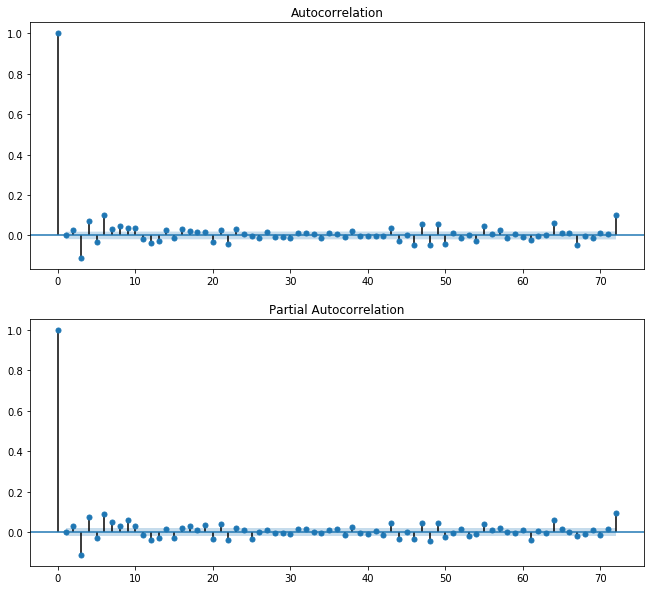

In [170]:
fig = plt.figure(figsize=(11,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results3.resid, lags=72, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results3.resid, lags=72, ax=ax2)

In [176]:
from statsmodels.stats.diagnostic import het_arch
het_arch(results3.resid,)

(1233.150313647418,
 1.4555327147636774e-232,
 34.51032317417583,
 1.9326029462217716e-247)

In [92]:
df['sezonowa']=sezonowa

In [93]:
df['sezonowa']

2017-01-01 01:00:00   -37.074285
2017-01-01 02:00:00   -38.994212
2017-01-01 03:00:00   -42.358139
2017-01-01 04:00:00   -44.636279
2017-01-01 05:00:00   -44.722626
2017-01-01 06:00:00   -40.232835
2017-01-01 07:00:00   -35.427148
2017-01-01 08:00:00   -29.169407
2017-01-01 09:00:00   -22.518196
2017-01-01 10:00:00   -13.069499
2017-01-01 11:00:00   -10.014767
2017-01-01 12:00:00    -9.821979
2017-01-01 13:00:00   -11.719027
2017-01-01 14:00:00   -16.121958
2017-01-01 15:00:00   -21.050604
2017-01-01 16:00:00   -21.911078
2017-01-01 17:00:00   -19.029157
2017-01-01 18:00:00   -11.519853
2017-01-01 19:00:00    -2.241464
2017-01-01 20:00:00    -0.984405
2017-01-01 21:00:00    -8.569971
2017-01-01 22:00:00   -18.080436
2017-01-01 23:00:00   -25.882211
2017-01-02 00:00:00   -35.037404
2017-01-02 01:00:00   -37.234690
2017-01-02 02:00:00   -38.882075
2017-01-02 03:00:00   -39.579273
2017-01-02 04:00:00   -39.250957
2017-01-02 05:00:00   -32.382947
2017-01-02 06:00:00   -20.916819
          

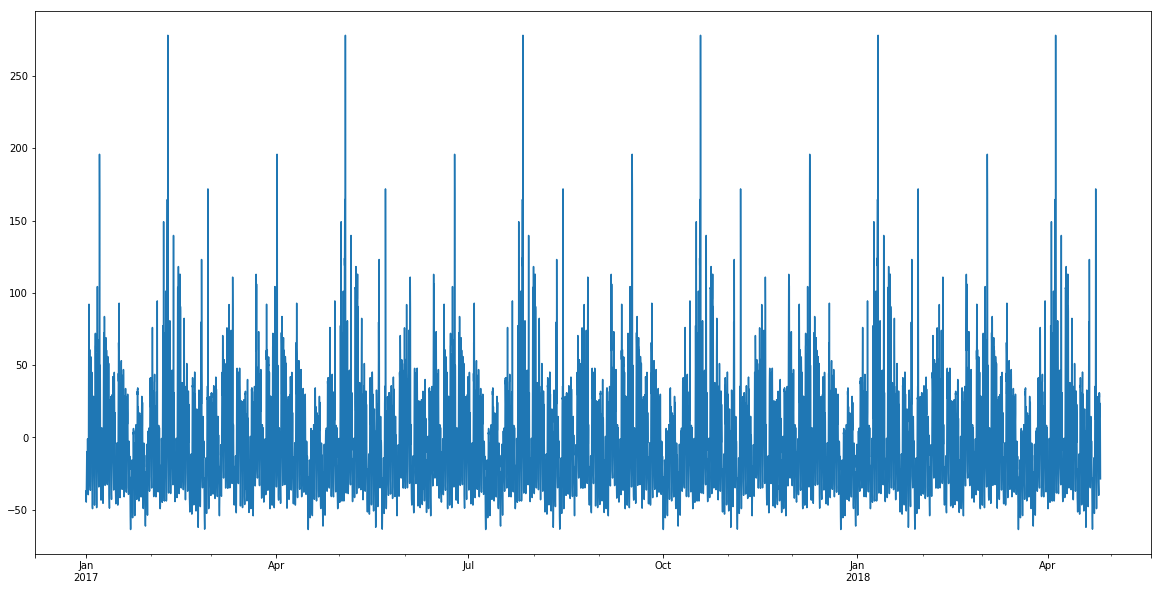

In [98]:
df['sezonowa'].plot(figsize=(20, 10))

In [204]:
model = sm.tsa.statespace.SARIMAX(treningowy,exog=X,trend='ct', order=(0,0,0), seasonal_order=(2,1,0,24),simple_differencing=True)
results4 = model.fit()
print (results4.summary())

C:\Users\Blizzardzik\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                            Statespace Model Results                            
Dep. Variable:            DS24.RDN 1fix   No. Observations:                11232
Model:             SARIMAX(2, 0, 0, 24)   Log Likelihood              -58010.095
Date:                  Wed, 29 Aug 2018   AIC                         116036.190
Time:                          22:50:51   BIC                         116094.802
Sample:                      01-02-2017   HQIC                        116055.916
                           - 04-15-2018                                         
Covariance Type:                    opg                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
intercept                             -0.0452      2.081     -0.022      0.983      -4.123       4.033
drift                               3.121e-

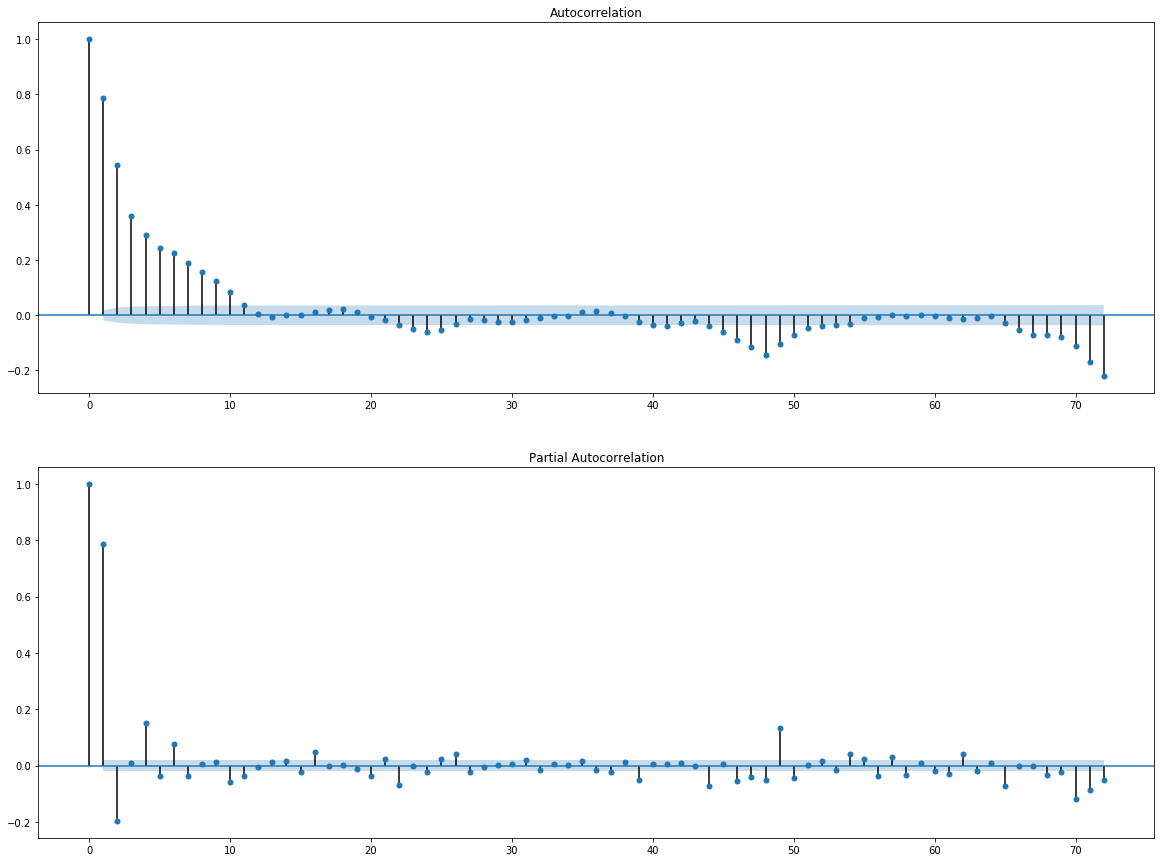

In [205]:
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results4.resid, lags=72, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results4.resid, lags=72, ax=ax2)

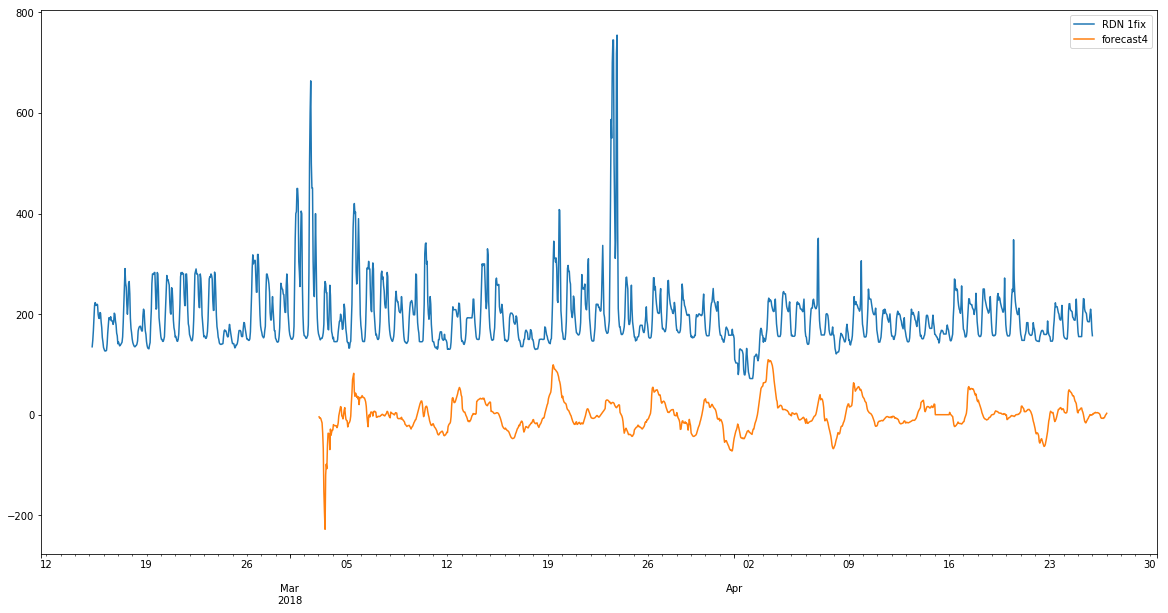

In [208]:
Xoos2=df[feature_cols][-312:]
df['forecast4'] = results4.predict(start = 10200, end= 11543, dynamic= True,exog=Xoos2)  
df[['RDN 1fix', 'forecast4']][-1700:].plot(figsize=(20, 10))

In [200]:
Xoos2

,Generacja wiatraków(PSE) w MWh,Krajowe Zapotrzebowanie na moc PSE,Generacja JWCD w MWh
2018-04-15 00:00:00,324.0,16200.0,11702.0
2018-04-15 01:00:00,729.0,15050.0,10362.0
2018-04-15 02:00:00,723.0,14325.0,9639.0
2018-04-15 03:00:00,697.0,14000.0,9328.0
2018-04-15 04:00:00,655.0,13825.0,9225.0
2018-04-15 05:00:00,605.0,13800.0,9258.0
2018-04-15 06:00:00,556.0,13550.0,9041.0
2018-04-15 07:00:00,513.0,13525.0,9053.0
2018-04-15 08:00:00,449.0,14375.0,9937.0
2018-04-15 09:00:00,330.0,15350.0,10969.0


In [209]:
from statsmodels.tsa.statespace.tools import diff

In [226]:
x=diff(treningowy,seasonal_periods=24,k_seasonal_diff=2) ## różnicowanie sezonowe

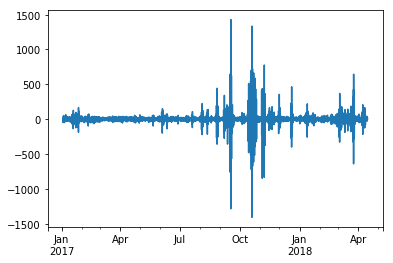

In [227]:
x.plot()

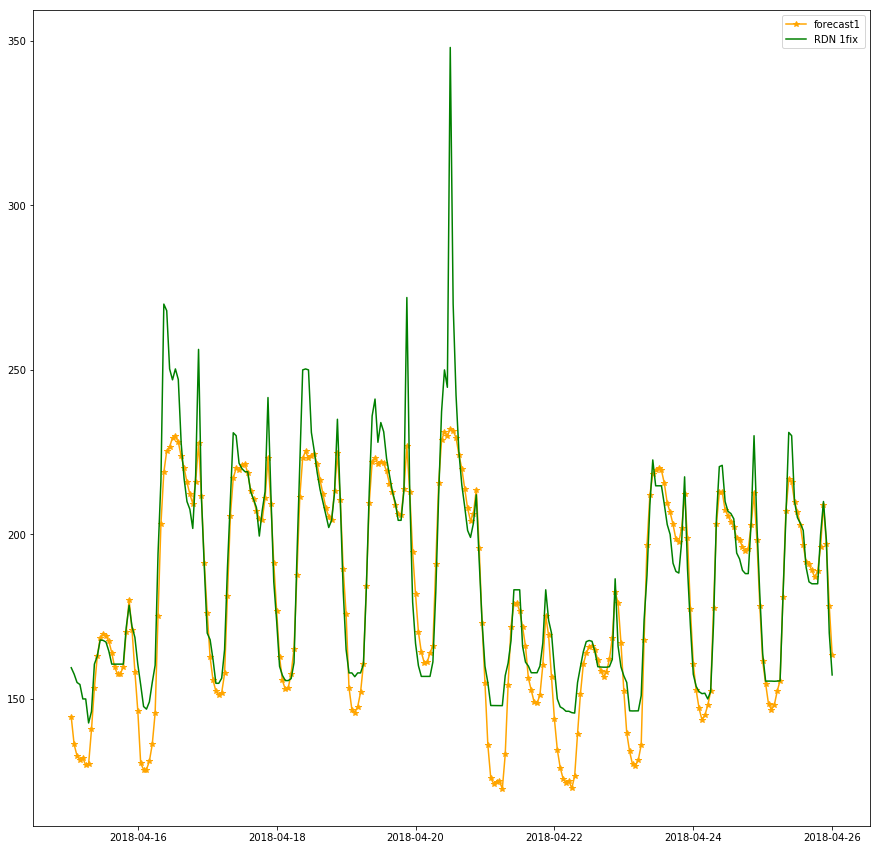

In [244]:
plt.figure(figsize=(15,15))
plt.plot(df['forecast1'][11256:11520],color='orange',marker='*')
#plt.plot(df['forecast3'][11256:11520],color='red',marker='o')
#plt.plot(df['forecast2'][11256:11520],color='blue',marker='x')
plt.plot(df['RDN 1fix'][11256:11520],color='green')
plt.legend()